# BMEN 509 Introduction to Biomedical Imaging and Applications
## Term Project - 3D Printed Anatomy: Implementation and Application of Mesh Tomography

Group 1 Team Members: 
- Elyse Poupart, UCID: 30063027
- Matthew Scott, UCID: 30072311
- Tyler Yip, UCID: 30062807
- Andrew Lattimer, UCID: 30062064

### Objectives
The objective of this project is to produce accurate and detailed 3D models of bones using image data transformation and various digital image processing techniques learned in class. The process will involve an evaluation of the different techniques available and their respective advantages and disadvantages. This information will be documented and analyzed to inform the choice of the most appropriate method for the project.

Noise elimination will be an essential step in the processing stage as it will help to create a clean, continuous and accurate final model. The elimination of noise in the data will help to improve the overall quality and reliability of the model and reduce the chances of errors or inaccuracies.

The ultimate goal is to develop an efficient processing method that can generate high-quality 3D models that are accurate, reliable and suitable for medical applications. If time permits, the processed data will be used to create a physical model using the 3D printers available from the Schulich makerspace. This physical model will then be used as a reference for the iterative design process, helping to identify and improve any shortcomings in the data processing methodology.

The iterative design process will aim to refine the data processing methodology and improve the overall quality of the model. This will involve evaluating the physical product against the original data and identifying any limitations or areas for improvement. The goal is to continuously improve the model until it is of a high enough quality to be used for various applications, such as in medical research, surgical planning or in the design of prosthetics.


### Setup and Configuration

We first install any dependencies and load libraries needed for processing

In [1]:
# Install dependencies
%pip install nibabel # Install nibabel for working with NIfTI
%pip install numpy-stl # Numpy-STL for exporting the mesh as a .stl file.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import os
import nibabel as nib
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from stl import mesh
import cv2

# Matplotlib configuration
%matplotlib inline

# Numpy configuration
np.set_printoptions(precision=2)

In [3]:
# Input file path setup
data_directory = os.path.join('.', 'data')
raw_images = ['001-CT.nii', '002-CT.nii', '003-CT.nii']
graphcut_images = ['001-graphcut.nii', '002-graphcut.nii', '003-graphcut.nii']
manual_segmented_images = ['001-manual.nii', '002-manual.nii', '003-manual.nii']

# Verify input files are available on current working directory
for file_name in raw_images + graphcut_images + manual_segmented_images:
    name = os.path.join(data_directory, file_name)
    if not os.path.isfile(name):
        os.sys.exit('Cannot find file {}. Please make sure you have downloaded the data'.format(name))
print('Found all image files!')

Found all image files!


### Exploratory Data Analysis

The objective of this phase of the project is to explore properties of the dataset we are using. Since the dataset includes a manually segmented image for each of our raw CT images, we can examine them side by side to gain insight into how we might approach segmentation and pre-processing. 

In [4]:
# We start by loading the first raw image and its included manual segmentation.

# Load the first raw CT image
ct001 = nib.load(os.path.join(data_directory, raw_images[0])).get_fdata()
print("The shape of ct001:", ct001.shape)

# Load the first manually segmented CT image
ct001_manual = nib.load(os.path.join(data_directory, manual_segmented_images[0])).get_fdata()
print("The shape of ct001_manual:", ct001_manual.shape)

The shape of ct001: (215, 124, 452)
The shape of ct001_manual: (215, 124, 452)


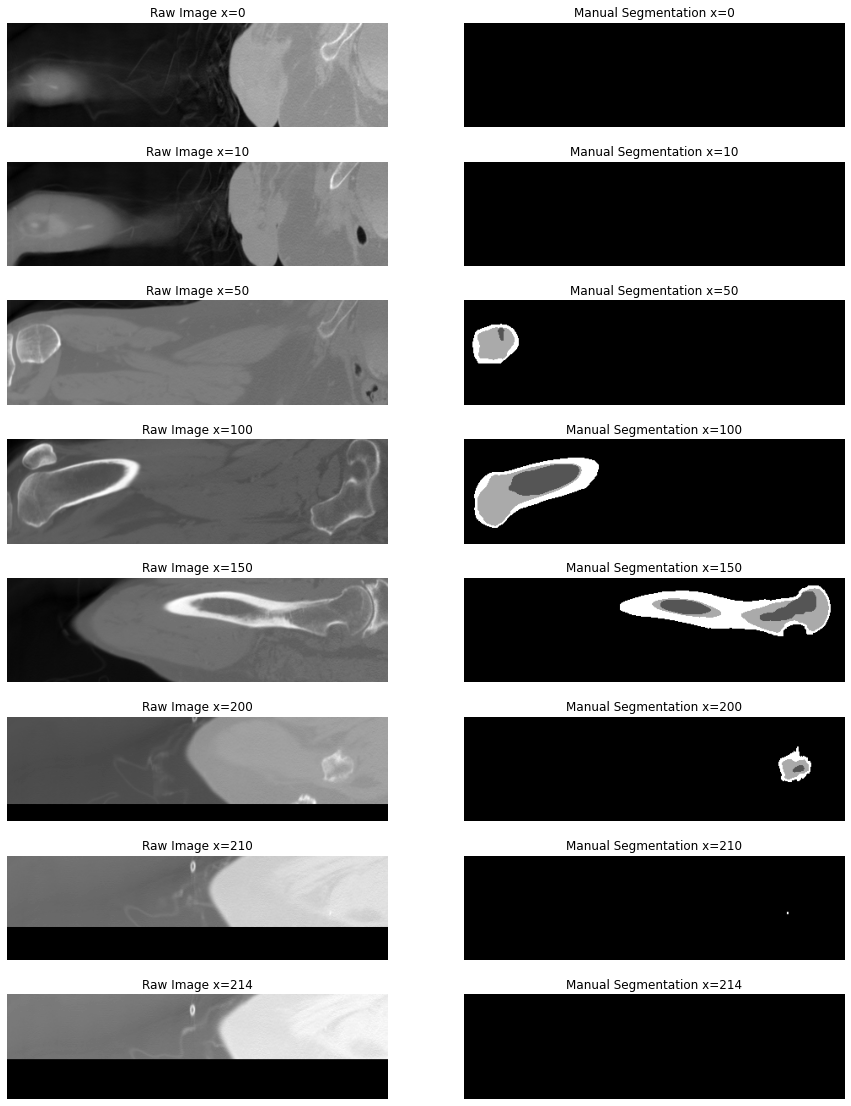

In [5]:
# Visualize a few slices from both the raw image and manually segmented image.
plt.figure(figsize=(15, 20))
subplot_idx = 1

for slice_x in [0, 10, 50, 100, 150, 200, 210, 214]:
    ct_slice = ct001[slice_x,:,:]
    ct_manual_slice = ct001_manual[slice_x,:,:]

    plt.subplot(8, 2, subplot_idx)
    plt.imshow(ct_slice, cmap='gray')
    plt.title(f'Raw Image x={slice_x}')
    plt.axis('off')

    plt.subplot(8, 2, subplot_idx + 1)
    plt.imshow(ct_manual_slice, cmap='gray')
    plt.title(f'Manual Segmentation x={slice_x}')
    plt.axis('off')

    subplot_idx += 2

plt.show()

In [6]:
# Based on our exploratory analysis of the image using ITK-Snap, we discovered that the bone in the x-dimension is visible in the slice range of x=10 to x=210. 
# We will use this information to crop our images in the x-dimension to eliminate data that may cause errors in our segmentation and mesh building.

# Crop CT001 to the region in the x-plane where the bone is visible
cropped_ct001 = ct001[10:210,:,:]
print("The shape of CT001 after cropping to the bone regions:", cropped_ct001.shape)

cropped_ct001_manual = ct001_manual[10:210,:,:]
print("The shape of CT001_manual after cropping to the bone regions:", cropped_ct001_manual.shape)

The shape of CT001 after cropping to the bone regions: (200, 124, 452)
The shape of CT001_manual after cropping to the bone regions: (200, 124, 452)


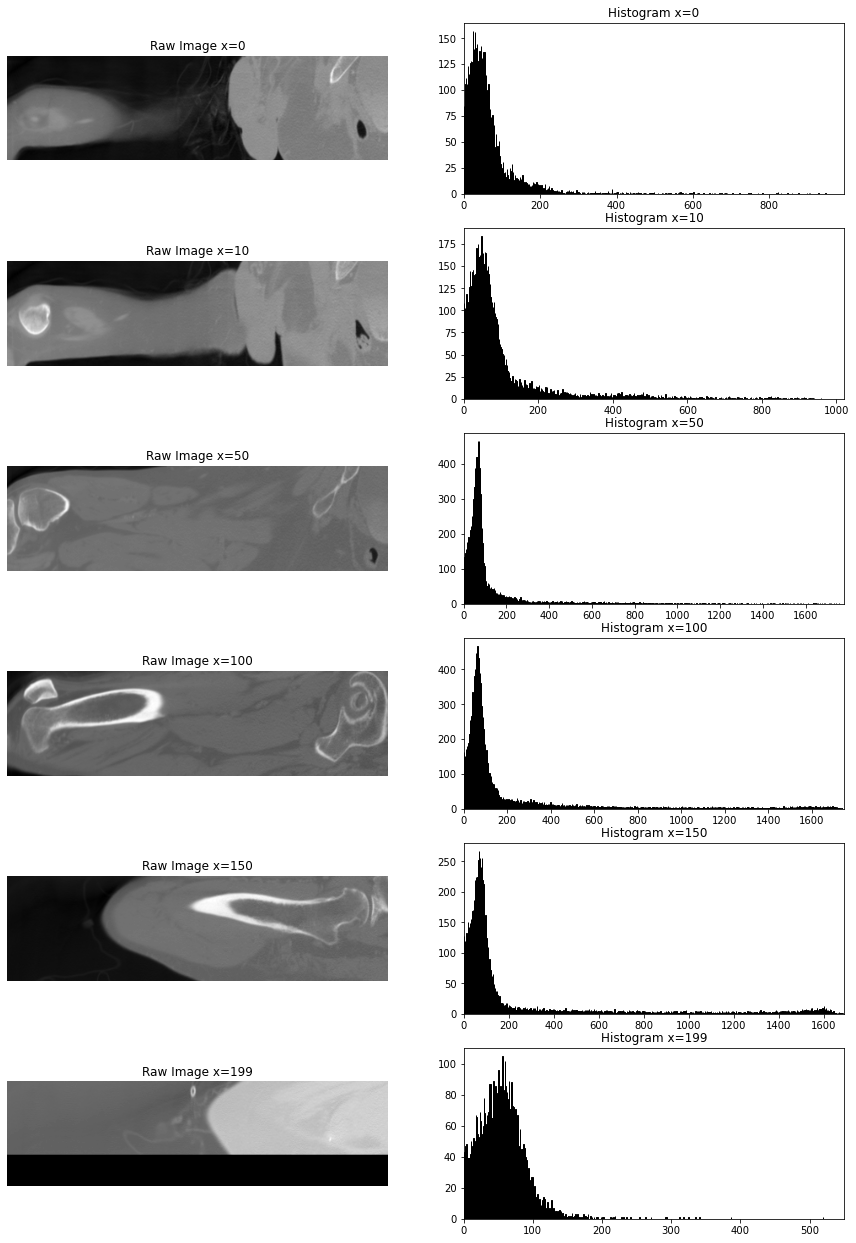

In [7]:
# We can now shift our focus towards analyzing the intensity profile of the scan by plotting the histogram of several slices.
plt.figure(figsize=(15, 22))
subplot_idx = 1

for slice_x in [0, 10, 50, 100, 150, 199]:
    ct_slice = cropped_ct001[slice_x,:,:]

    # Plot the image
    plt.subplot(6, 2, subplot_idx)
    plt.imshow(ct_slice, cmap='gray')
    plt.title(f'Raw Image x={slice_x}')
    plt.axis('off')

    # We determine the number of bins to use dynamically to save on memory and compute time
    hist_max = np.max(ct_slice.flatten())
    hist_max = hist_max.astype(np.int64)

    # Plot the histogram
    plt.subplot(6, 2, subplot_idx + 1)
    plt.hist(ct_slice.flatten(), hist_max, [0,hist_max], fc='k', ec='k')
    plt.xlim([0,hist_max])
    plt.title(f'Histogram x={slice_x}')

    subplot_idx += 2

plt.show()

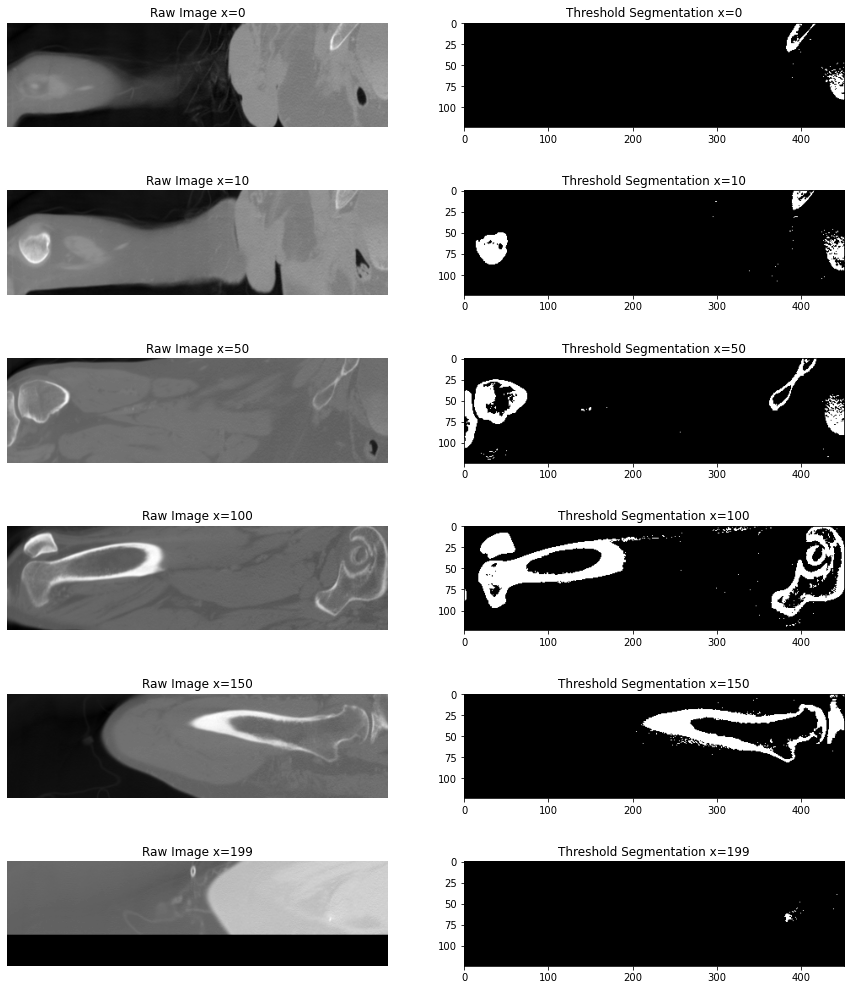

In [8]:
# Based on the histograms above, it appears that 200 is a good value for threshold segmentation. 
threshold = 150

# We can try threshold segmentation using 200 on a few slices
plt.figure(figsize=(15, 18))
subplot_idx = 1

for slice_x in [0, 10, 50, 100, 150, 199]:
    ct_slice = cropped_ct001[slice_x,:,:]

    # Plot the image
    plt.subplot(6, 2, subplot_idx)
    plt.imshow(ct_slice, cmap='gray')
    plt.title(f'Raw Image x={slice_x}')
    plt.axis('off')

    mask = np.zeros_like(ct_slice,'uint8')
    mask[ct_slice <= threshold] = 0          
    mask[ct_slice > threshold] = 1

    # Plot the histogram
    plt.subplot(6, 2, subplot_idx + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Threshold Segmentation x={slice_x}')

    subplot_idx += 2

plt.show()

In [9]:
# Define a function to threshold segment an image given the image and a threshold value
def threshold_segment(image, threshold):
    mask = np.zeros_like(image,'uint8')
    mask[image <= threshold] = 0          
    mask[image > threshold] = 1

    return mask

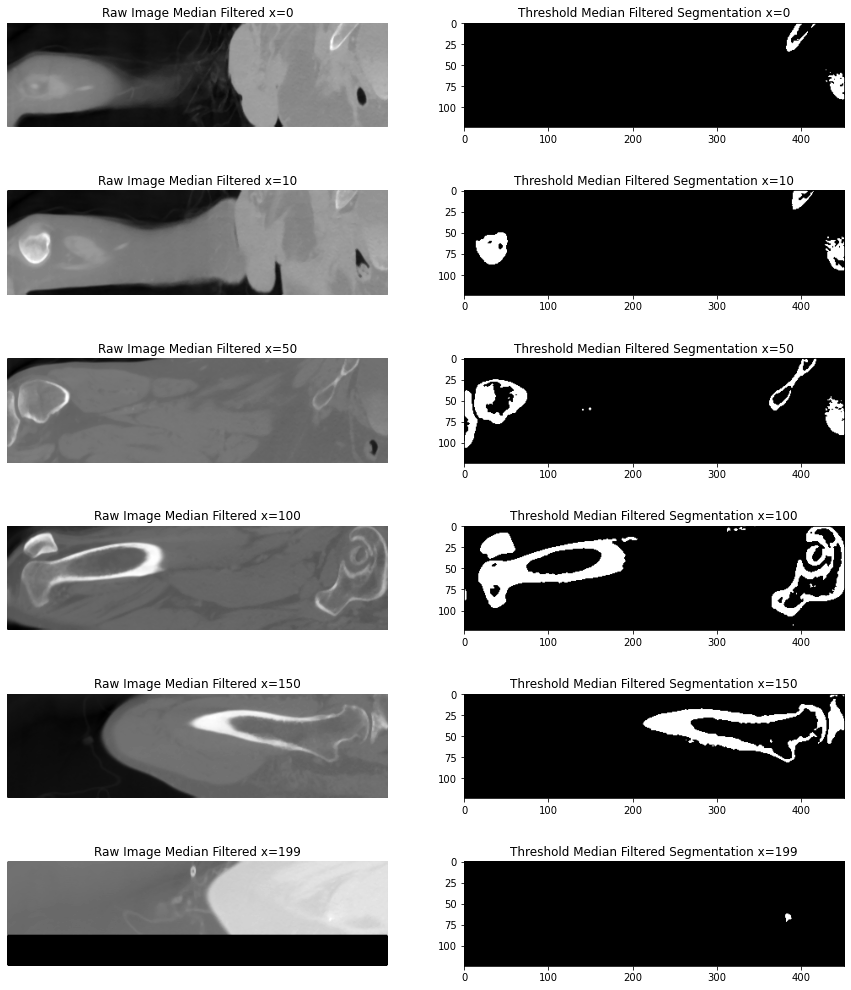

In [10]:
# Let's try threshold segmentation on an image after applying a low pass filter like the median filter.
from scipy.signal import medfilt

plt.figure(figsize=(15, 18))
subplot_idx = 1

for slice_x in [0, 10, 50, 100, 150, 199]:
    ct_slice = cropped_ct001[slice_x,:,:]

    # Apply the median filter with a kernel size of 3
    ct_slice=medfilt(ct_slice, 3)

    # Plot the image
    plt.subplot(6, 2, subplot_idx)
    plt.imshow(ct_slice, cmap='gray')
    plt.title(f'Raw Image Median Filtered x={slice_x}')
    plt.axis('off')

    mask = threshold_segment(ct_slice, threshold)

    # Plot the segmentation
    plt.subplot(6, 2, subplot_idx + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Threshold Median Filtered Segmentation x={slice_x}')

    subplot_idx += 2

plt.show()

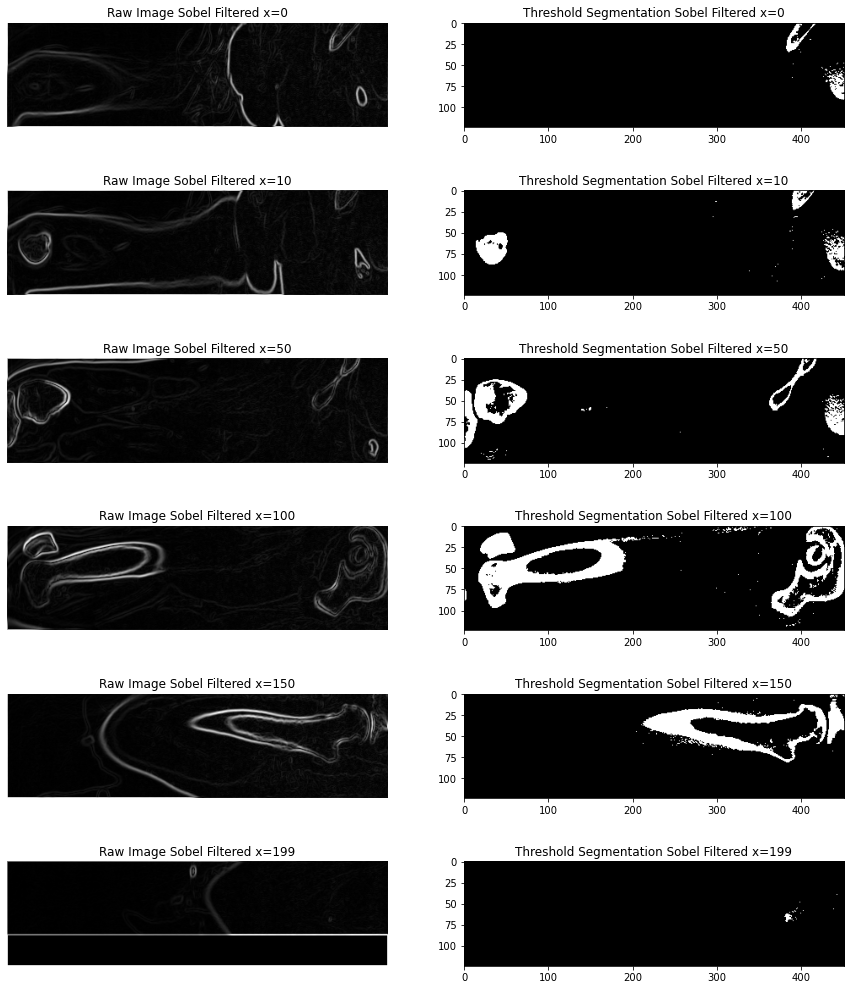

In [11]:
# Let's try threshold segmentation on an image after applying a high pass filter like the Sobel filter.
from scipy import ndimage

plt.figure(figsize=(15, 18))
subplot_idx = 1

for slice_x in [0, 10, 50, 100, 150, 199]:
    ct_slice = cropped_ct001[slice_x,:,:]

    # Apply the median filter with a kernel size of 3
    ct_slice_sobel_fx=ndimage.sobel(ct_slice,axis=0, mode='constant')
    ct_slice_sobel_fy=ndimage.sobel(ct_slice,axis=1, mode='constant')
    ct_slice_sobel_f=np.hypot(ct_slice_sobel_fx, ct_slice_sobel_fy)

    # Plot the image
    plt.subplot(6, 2, subplot_idx)
    plt.imshow(ct_slice_sobel_f, cmap='gray')
    plt.title(f'Raw Image Sobel Filtered x={slice_x}')
    plt.axis('off')

    mask = threshold_segment(ct_slice, threshold)

    # Plot the segmentation
    plt.subplot(6, 2, subplot_idx + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Threshold Segmentation Sobel Filtered x={slice_x}')

    subplot_idx += 2

plt.show()

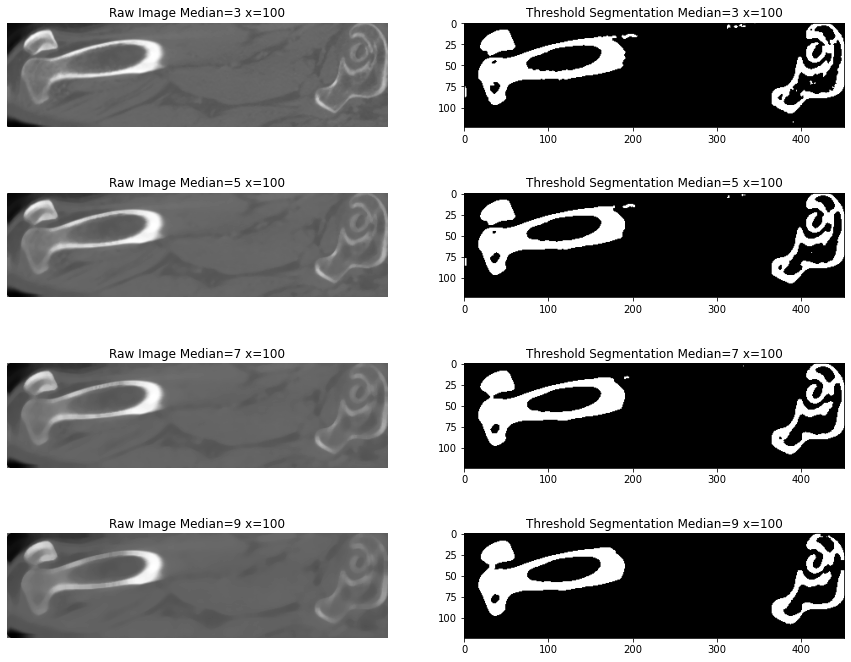

In [12]:
# The Sobel filtered performed terribly, so let's experiment with different kernel sizes for our median filter. We only need to examine a single slice, so let's use x=100
plt.figure(figsize=(15, 12))
subplot_idx = 1

slice_100 = cropped_ct001[100,:,:]

for kernel in [3, 5, 7, 9]:
    # Apply the median filter with a kernel size of 3
    ct_slice=medfilt(slice_100, kernel)

    # Plot the image
    plt.subplot(4, 2, subplot_idx)
    plt.imshow(ct_slice, cmap='gray')
    plt.title(f'Raw Image Median={kernel} x=100')
    plt.axis('off')

    mask = threshold_segment(ct_slice, threshold)

    # Plot the histogram
    plt.subplot(4, 2, subplot_idx + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Threshold Segmentation Median={kernel} x=100')

    subplot_idx += 2

plt.show()

### Segmentation

Based on our exploratory data analysis phase, we discovered that threshold segmentation performs best after applying a low pass filter like the median filter. However, too much filtering and the smaller elements in an image can become blurred together, merging areas where two bones are close together.

The process we will apply to compute the segmentation for our images is as follows:
1. Loop through each slice
2. Apply the median filter
3. Segment based on a threshold
4. Combine the segmented slices back into a single image

In [13]:
# Define a function to perform the filtering and segmentation for each slice
def segment_slice(slice, kernel_size, threshold):
    # Filter the slice using the median filter
    filtered_slice = medfilt(slice, kernel_size)

    # Segment the filtered slice
    slice_segment = np.zeros_like(filtered_slice,'uint8')
    slice_segment[slice[:,:] <= threshold] = 0          
    slice_segment[slice[:,:] > threshold] = 1

    return slice_segment

In [14]:
# Use the segment_slice() function to segment the entire 3D image (volumetric segmentation)
segmentation = np.zeros_like(cropped_ct001,'uint8')

# Iterate through each slice, applying the segmentation to each.
for slice_idx in range(0, 200):
    segmentation[slice_idx,:,:] = segment_slice(cropped_ct001[slice_idx,:,:], kernel_size=3, threshold=160)

In [15]:
# Define a function to eliminate the non-largest region in each slice to remove non-femur bones
def eliminate_non_largest_region(arr):
    newarr = np.zeros_like(arr, dtype=np.uint8)
    for i in range(arr.shape[0]):
        # Detect all the regions within the mask
        ret, markers = cv2.connectedComponents(arr[i, :, :])
        if ret < 2:
            continue  # Skip if there are no regions
        
        # Determine which of the regions has the highest number of pixels using a histogram
        hist, bins = np.histogram(markers.flatten(), ret, [0, ret])
        inxhist = np.argsort(hist)  # Indexes of the sorted histogram
        inxbone = inxhist[-2]  # Index of the second last region (the last being the most frequent)
        
        # Extract the largest region
        ROI = np.zeros_like(arr[i, :, :], dtype=np.uint8)
        ROI[np.where(markers == inxbone)] = 1  # Turn to 1 only those pixels that are in the largest region
        newarr[i, :, :] = ROI
    
    return newarr

In [16]:
# Creating a new 3d array that has only the largest continuous region retained
largest_segmentation=eliminate_non_largest_region(segmentation)

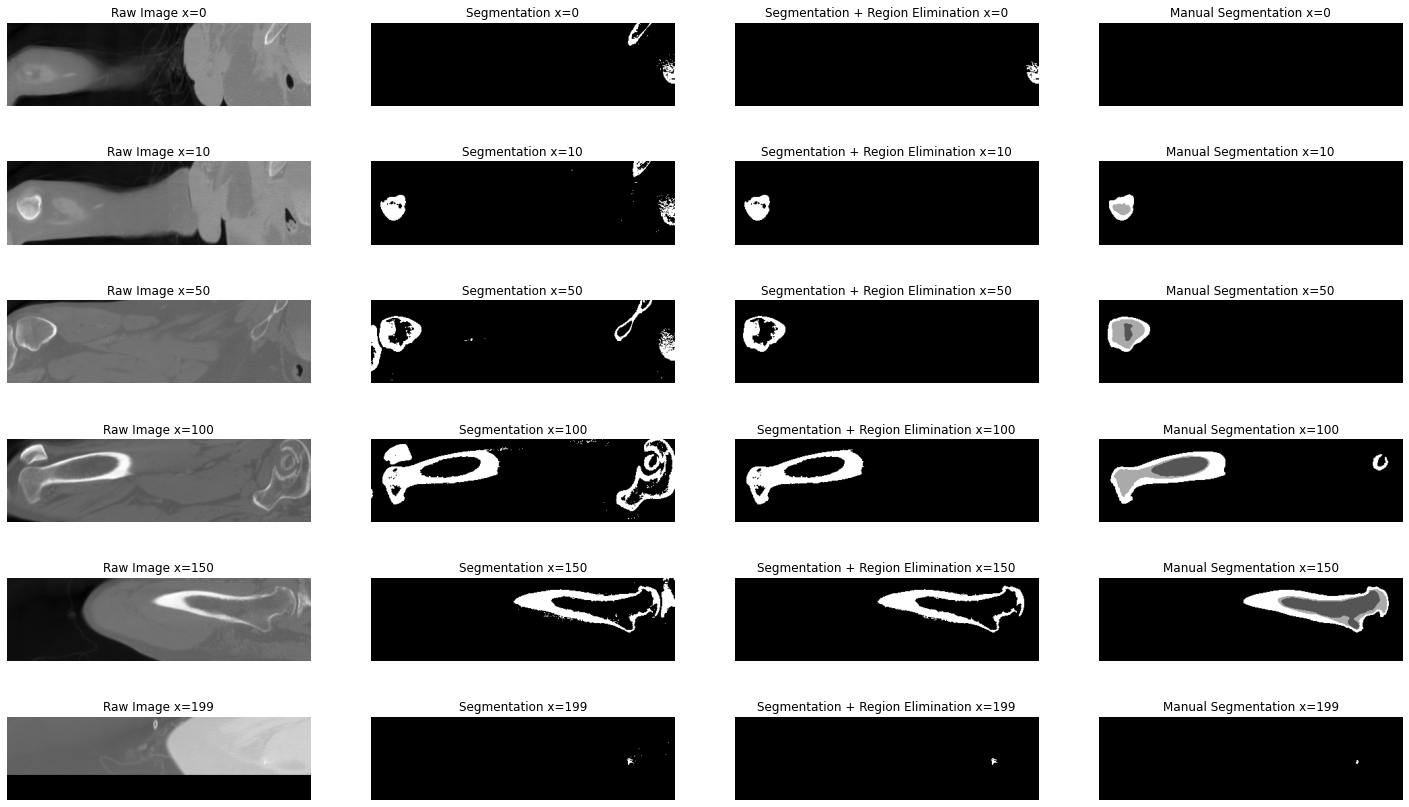

In [17]:
# Visualize a few slices from the raw image, our segmentations, and the manually segmented image.
plt.figure(figsize=(25, 20))
subplot_idx = 1

for slice_x in [0, 10, 50, 100, 150, 199]:
    ct_slice = cropped_ct001[slice_x,:,:]
    segmented_ct_slice = segmentation[slice_x,:,:]
    segmented_largest_ct_slice = largest_segmentation[slice_x,:,:]
    ct_manual_slice = cropped_ct001_manual[slice_x,:,:]

    plt.subplot(8, 4, subplot_idx)
    plt.imshow(ct_slice, cmap='gray')
    plt.title(f'Raw Image x={slice_x}')
    plt.axis('off')

    plt.subplot(8, 4, subplot_idx + 1)
    plt.imshow(segmented_ct_slice, cmap='gray')
    plt.title(f'Segmentation x={slice_x}')
    plt.axis('off')

    plt.subplot(8, 4, subplot_idx + 2)
    plt.imshow(segmented_largest_ct_slice, cmap='gray')
    plt.title(f'Segmentation + Region Elimination x={slice_x}')
    plt.axis('off')

    plt.subplot(8, 4, subplot_idx + 3)
    plt.imshow(ct_manual_slice, cmap='gray')
    plt.title(f'Manual Segmentation x={slice_x}')
    plt.axis('off')

    subplot_idx += 4

plt.show()

### Mesh Generation

Once we have properly segmented the image, we need to generate the 3d mesh so we can print the volumetric segmentation. We also need to visually examine it to make sure our segmentation succeeded.

In [18]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact_manual, interact

def make_mesh(image):
    p=image
    # generation of the vertices and faces of polygons using marching cubes
    verts, faces, _, _ = measure.marching_cubes(p) 
    return verts, faces

In [19]:
def plt_3d(verts, faces, orientationX, orientationY):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    x,y,z = zip(*verts) 
        
    # verts[faces] generates a collection of triangles which is needed by Poly3DCollection
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    
    face_color = [0.89, 0.85, 0.79]    #bone colour
    mesh.set_facecolor(face_color)    
    mesh.set_edgecolor([0,0,0])    #black
    ax.add_collection3d(mesh)    #creates the volume image

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    
    ax.view_init(orientationX, orientationY)   #sets the orientation of the view
    
    plt.show() 

In [20]:
cropped_ct001_manual_verts, cropped_ct001_manual_faces = make_mesh(cropped_ct001_manual[:,::,::])   #calls function to create mesh

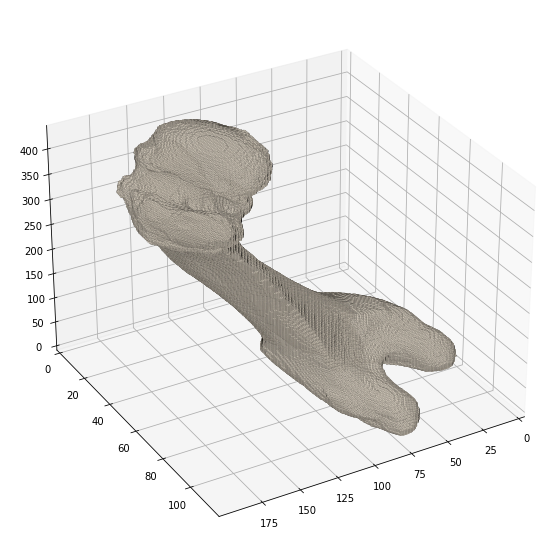

In [21]:
plt_3d(cropped_ct001_manual_verts, cropped_ct001_manual_faces, 30,60);   #calls function to plot and opens a pager with execution information

In [22]:
cropped_segmentation_verts, cropped_segmentation_faces = make_mesh(segmentation[:,::,::])   #calls function to create mesh

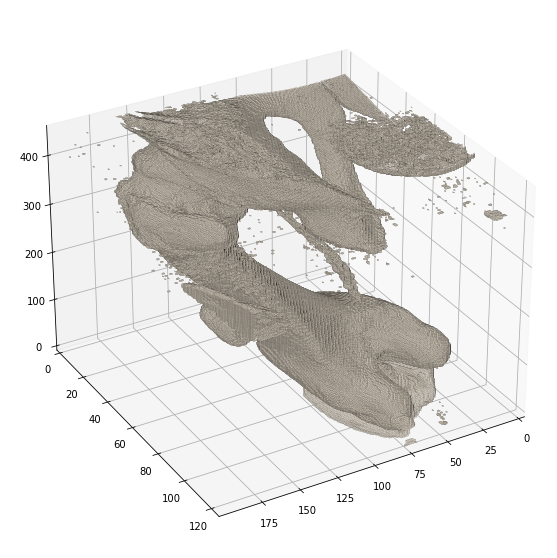

In [23]:
plt_3d(cropped_segmentation_verts, cropped_segmentation_faces, 30,60);   #calls function to plot and opens a pager with execution information

In [24]:
cropped_segmentation_elimination_verts, cropped_segmentation_elimination_faces = make_mesh(largest_segmentation[:,::,::])   #calls function to create mesh

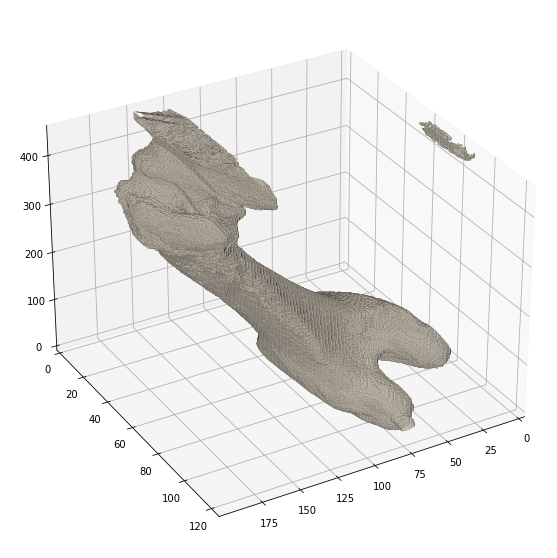

In [25]:
plt_3d(cropped_segmentation_elimination_verts, cropped_segmentation_elimination_faces, 30,60);   #calls function to plot and opens a pager with execution information

### Convert Mesh to .stl File For Printing

The last step in our process is to convert our mesh into a 3D-printed friendly file format known as a .stl file.

In [26]:
# Define a function to create a mesh given an array of faces and vertices
def make_mesh(faces, vertices):
    new_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            new_mesh.vectors[i][j] = vertices[f[j], :] # Generate the vector for each face

    return new_mesh

In [27]:
segmentation_mesh_filename = "segmentation_mesh.stl"
segmentation_elimination_mesh_filename = "segmentation_elimination_mesh.stl"
segmentation_manual_mesh_filename = "segmentation_manual_mesh.stl"

# Create meshes
segmentation_mesh = make_mesh(cropped_segmentation_faces, cropped_segmentation_verts)
segmentation_elimination_mesh = make_mesh(cropped_segmentation_elimination_faces, cropped_segmentation_elimination_verts)
segmentation_manual_mesh = make_mesh(cropped_ct001_manual_faces, cropped_ct001_manual_verts)

# Write mesh to a .stl file
segmentation_mesh.save(segmentation_mesh_filename)
segmentation_elimination_mesh.save(segmentation_elimination_mesh_filename)
segmentation_manual_mesh.save(segmentation_manual_mesh_filename)